# Evaluating and Tuning a Binary Classification Model

## Goals

After this lesson, you should be able to:

- Build and explain confusion matrices from a model output
- Calculate various binary classification metrics
- Explain the AUC/ROC curve, why it matters, and how to use it
- Understand when and how to optimize a model for various metrics
- Optimize a classification model based on costs

### Category definitions - possible outcomes in binary classification
 
#### - TP = True Positive (class 1 correctly classified as class 1) - e.g. Patient with cancer tests positive for cancer
#### - TN = True Negative (class 0 correctly classified as class 0) - e.g. Patient without cancer tests negative for cancer
#### - FP = False Positive (class 0 incorrectly classified as class 1) - e.g. Patient without cancer tests positive for cancer
#### - FN = False Negative (class 1 incorrectly classified as class 0) - e.g. Patient with cancer tests negative for cancer

### $$ \text{Possible misclassifications} $$

![Type 1 vs. Type 2 Error](images/type-1-type-2.jpg)

## Let's run a model and look at some metrics 

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('./data/heart.csv')

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df['target'].value_counts(normalize = True)

1    0.544554
0    0.455446
Name: target, dtype: float64

In [6]:
X = df.drop('target', axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 77, stratify = y, test_size = .5)

In [7]:
y_train.mean(), y_test.mean()

(0.543046357615894, 0.5460526315789473)

In [8]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 77)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=77, verbose=0, warm_start=False)

In [9]:
rf.score(X_test, y_test)

0.8355263157894737

### The Default Measure (in most prebuilt models) - Accuracy

$$ \frac{(TP + TN)}{(TP + FP + TN + FN)} $$

#### We got an accuracy score of .842, but what does that tell us? Just that 84.2% of the time we are correct, nothing about how we are correct or how we are wrong

In [10]:
predictions = rf.predict(X_test)
actual = y_test

In [11]:
confusion_matrix(actual, predictions)

array([[58, 11],
       [14, 69]])

#### My eyes!!!

In [12]:
pd.DataFrame(confusion_matrix(actual, predictions), columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,58,11
actual 1,14,69


#### We got more false negatives than false positives. What would we likely prefer in the case of this dataset?

## Other metrics

### Misclassification Rate
#### $$ 1 - \text{accuracy} $$ 

### $$ {OR} $$

#### $$ \frac{FP + FN}{TP + FP + TN + FN} $$

### Sensitivity (AKA True Positive Rate, Recall, and Probability of Detection)

$$ \frac{TP}{TP + FN} $$

### Specificity (AKA True Negative Rate)

$$ \frac{TN}{TN + FP} $$

#### Which of these metrics would we want to optimize for in a heart disease detection algorithm?

False Positives and False Negatives each have some cost associated with them.

### Let's figure out how to optimize!

#### Remember that Random Forest gives probability predictions for each class, in addition to the final classification. By default, a majority of trees voting for a class determines the classification, but we can adjust that threshold

In [13]:
predicts = []
for item in rf.predict_proba(X_test):
    if item[0] <= .49:
        predicts.append(1)
    else:
        predicts.append(0)

In [14]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicts), index = ['actual 0', 'actual 1'], 
             columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,58,11
actual 1,14,69


In [15]:
## accuracy

(conf_matrix['predicted 0'][0] + conf_matrix['predicted 1'][1]) / len(predicts)

0.8355263157894737

### The AUC / ROC curve (Area Under Curve of the Receiver Operating Characteristic)

In [16]:
import matplotlib.pyplot as plt

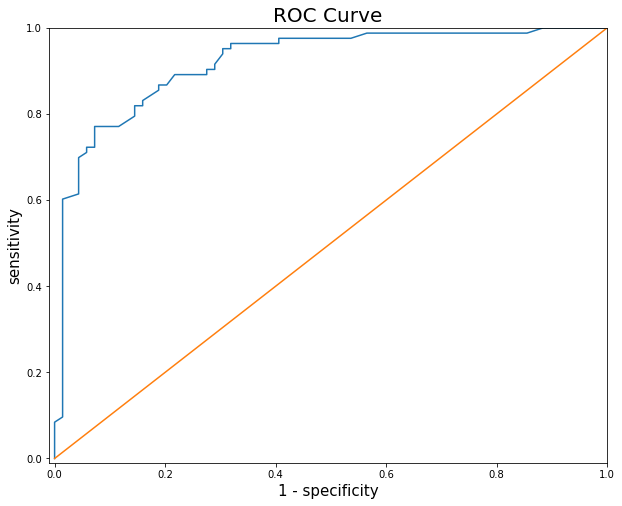

In [127]:
x_list = []
y_list = []

for x in np.linspace(0, 1, 100):
    
    # Same predictions based on predict_proba thresholds
    predicts = []
    
    for item in rf.predict_proba(X_test):
        if item[0] <= x:
            predicts.append(1)
        else:
            predicts.append(0)

    conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicts), index = ['actual 0', 'actual 1'], 
                     columns = ['predicted 0', 'predicted 1'])
    
    
    # Assign TP, TN, FP, FN
    true_positives = conf_matrix['predicted 1'][1]
    true_negatives = conf_matrix['predicted 0'][0]
    false_positives = conf_matrix['predicted 1'][0]
    false_negatives = conf_matrix['predicted 0'][1]

    
    # Calculate Sensitivity and Specificity
    sensitivity = true_positives / (true_positives + false_negatives)

    specificity = true_negatives / (true_negatives + false_positives)
    
    
    # Append to lists to graph
    x_list.append(1 - specificity)

    y_list.append(sensitivity)

    
# Plot ROC curve

plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('1 - specificity', fontsize = 15)
plt.ylabel('sensitivity', fontsize = 15)
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 1)
plt.plot(x_list, y_list);
plt.plot([0, 1], [0, 1]);

# x = 1 - specificity
# y = sensitivity

In [125]:
from sklearn.metrics import auc

In [126]:
auc(x_list, y_list)

0.9202025493277458

### Let's add associated costs to our False Negatives and False Positives to our loop and minimize the cost
This is the naive way to optimize, but works well - you could also create a closed form optimization function

In [138]:
def my_eyes_cost_much(num_thres = 100, p_fp = 3, p_tn = 0.5, p_tp = 1, p_fn = 2):

    _thres = []; tpr = [] ; fpr = [] ; cost = []

    prediction = rf.predict_proba(X_test)

    ## Different code for same objective to calculate metrics at thresholds
    
    for thres in np.linspace(0.01, 1, num_thres):
        
        _thres.append(thres)
        predicts = np.zeros((prediction.shape[0], 1)) 
        predicts[np.where(prediction[:, 1] >= thres)] = 1

        conf_matrix = confusion_matrix(y_test, predicts)

        tp = conf_matrix[1, 1]
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1]
        fn = conf_matrix[1, 0]

        sensitivity = tp / (tp + fn)
        tnr = specificity = tn / (tn + fp)
        fnr = 1 - sensitivity

        tpr.append(sensitivity)
    
        fpr.append(1 - specificity)
        
        # add a cost function (this involves domain knowledge)
        
        current_cost = (p_fp * fp) + (p_tn * tn) + (p_tp * tp) + (p_fn * fn)
            
        cost.append(current_cost)  

    return fpr, tpr, cost, _thres

In [146]:
fpr, tpr, cost, thres = my_eyes_cost_much(num_thres = 100, p_fp = 3, p_tn = 0.5, p_tp = 1, p_fn = 2)

In [147]:
cost_idx = np.argmin(cost)
min_cost_threshold = fpr[cost_idx], tpr[cost_idx], thres[cost_idx]

Text(0.13246376811594202, 0.7410843373493976, 'Threshold:0.57')

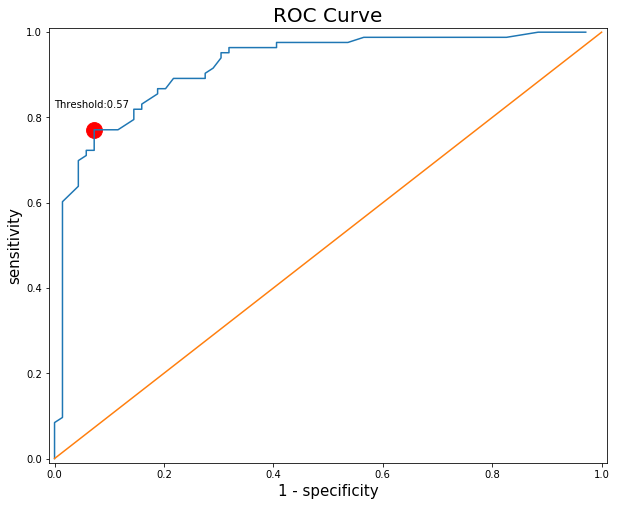

In [148]:
ax = plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('1 - specificity', fontsize = 15)
plt.ylabel('sensitivity', fontsize = 15)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1]);
plt.scatter(min_cost_threshold[0], min_cost_threshold[1], marker ='o', color = 'red', s=250)
ax.text(min_cost_threshold[0] + 0.06, min_cost_threshold[1] - 0.03, 'Threshold:'+ str(round(min_cost_threshold[2], 2)))


### Visualizing Threshold vs. Population Distribution

In [34]:
import seaborn as sns

In [131]:
rf.predict_proba(X_test)[:5]

array([[0.19, 0.81],
       [0.21, 0.79],
       [0.44, 0.56],
       [0.08, 0.92],
       [0.66, 0.34]])

In [134]:
rf.predict(X_test)[:5]

array([1, 1, 1, 1, 0])

In [135]:
no_cancer_dist = []
cancer_dist = []

for item in rf.predict_proba(X_test):
    if item[0] <= .49:
        cancer_dist.append(item[0])
    else:
        no_cancer_dist.append(item[0])

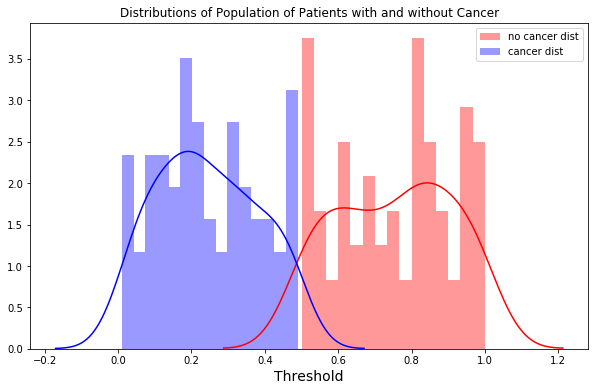

In [136]:
plt.figure(figsize = (10, 6))
plt.title('Distributions of Population of Patients with and without Cancer')
plt.xlabel('Threshold', fontsize = 14)

sns.distplot(no_cancer_dist, bins = 15, color = 'red')
sns.distplot(cancer_dist, bins = 15, color = 'blue')
plt.legend(['no cancer dist', 'cancer dist']);

### ROC curve vs Population Separation
![a](images/pop-curve.png)

![d](images/varying_dist_roc.png)

## All the Binary Classification Metrics

![classification metrics](./images/conf_matrix_classification_metrics.png)

### Precision (Positive Predictive Value)

### $$ \frac{TP}{TP + FP}  $$

### F1 Score

### $$ 2 * \frac{\text{Precision * Recall}}{\text{Precision + Recall}} $$